In [1]:
import os
import random
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from skimage.io import imread

np.set_printoptions(precision = 2)
np.set_printoptions(suppress  = True)

In [2]:
def normalize(img):
    img_cop  = img.copy()
    img_cop  = img_cop.astype('float64') 
    img_min  = np.min(img_cop)
    img_max  = np.max(img_cop)
    img_cop  = (img_cop - img_min)/(img_max - img_min)
    return img_cop

def load(filename):
    # Get global dictionary
    glob = globals()
    with open(filename, 'rb') as f:
        for k, v in pickle.load(f).items():
            # Set each global variable to the value from the file
            glob[k] = v

In [5]:
images_path = 'images/'
masks_path  = 'masks/'

In [9]:
model = tf.keras.models.load_model('model_segmentation')

images_paths = sorted(
    [os.path.join(images_path, fname)
     for fname in os.listdir(images_path)
     if fname.endswith(".png")]
)

masks_paths = sorted(
    [os.path.join(masks_path, fname)
     for fname in os.listdir(masks_path)
     if fname.endswith(".png") and not fname.startswith(".")]
)

val_samples = 10
random.Random(1337).shuffle(images_paths)
random.Random(1337).shuffle(masks_paths)
train_images_paths = images_paths
train_masks_paths  = masks_paths
test_images_paths  = images_paths[-val_samples:]
test_masks_paths   = masks_paths[-val_samples:]

img_height    = 256
img_width     = 256
img_channels  = 3

In [14]:
X_test = np.zeros((len(test_images_paths), img_height, img_width, img_channels), dtype= 'uint8')
Y_test = np.zeros((len(test_masks_paths), img_height, img_width, 1), dtype = np.bool_)

for i in range(len(test_images_paths)):   
    img = imread(test_images_paths[i])[:,:,:img_channels] 
    img = np.around(255*normalize(img)).astype('uint8')
    X_test[i] = img  #Fill empty X_train with values from img

for i in range(len(test_masks_paths)):   
    img = np.mean(imread(test_masks_paths[i]), 2)
    print(np.max(img))
    img = 1.0 * (img > 40)
    img = np.expand_dims(img, axis=2)
    Y_test[i] = img  #Fill empty Y_train with values from img 



42.666666666666664
42.666666666666664
42.666666666666664
42.666666666666664
42.666666666666664
42.666666666666664
42.666666666666664
42.666666666666664
42.666666666666664
42.666666666666664


In [6]:
val_samples = 20
Y_test_pred = model.predict(X_test, verbose=1)

2/2 [==============================] - 2s 792ms/step


1/1 [==============================] - 0s 395ms/step


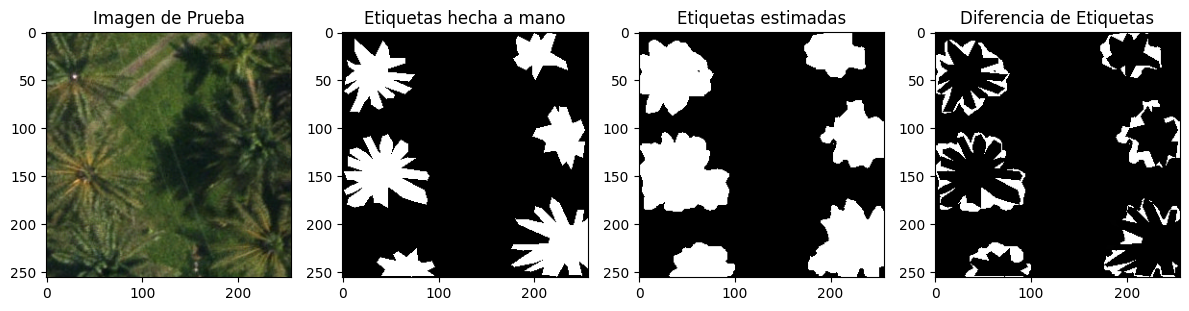

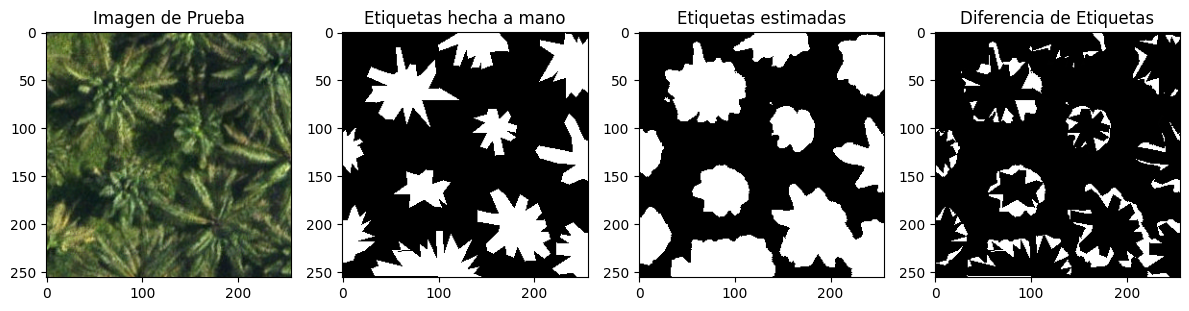

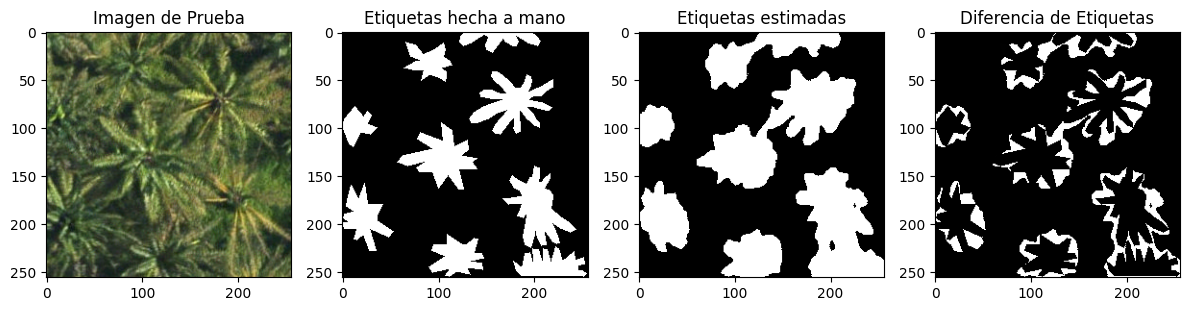

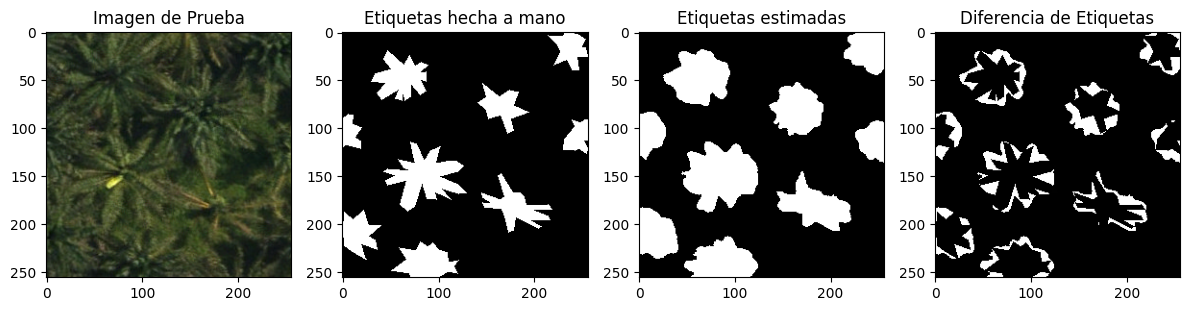

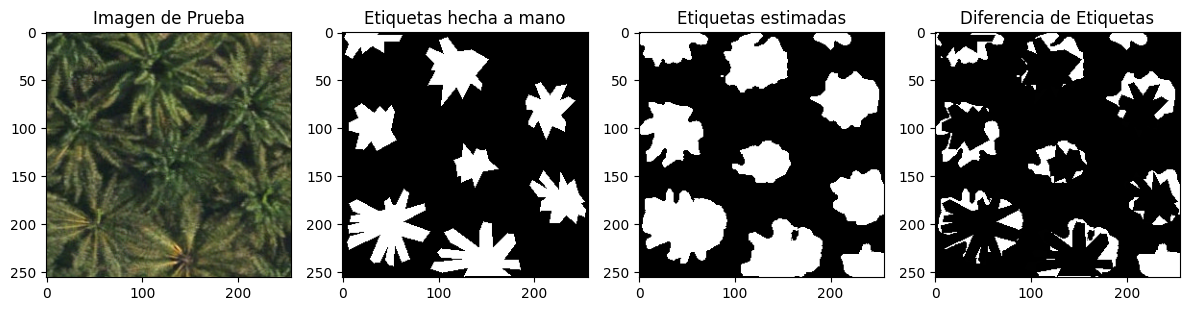

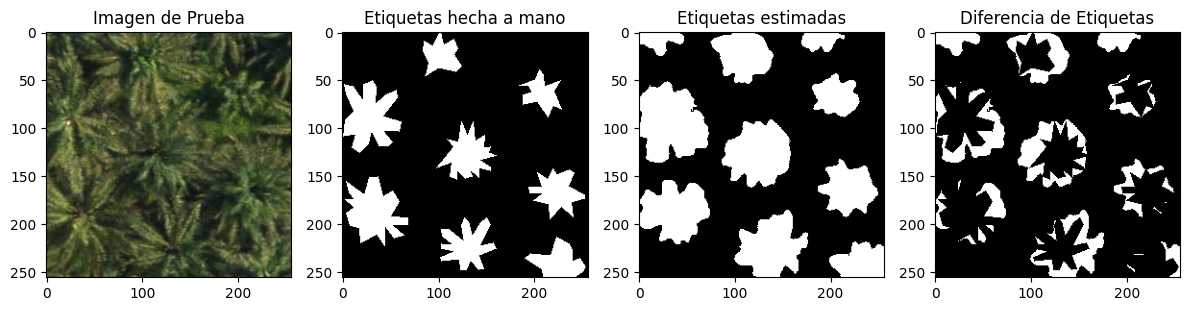

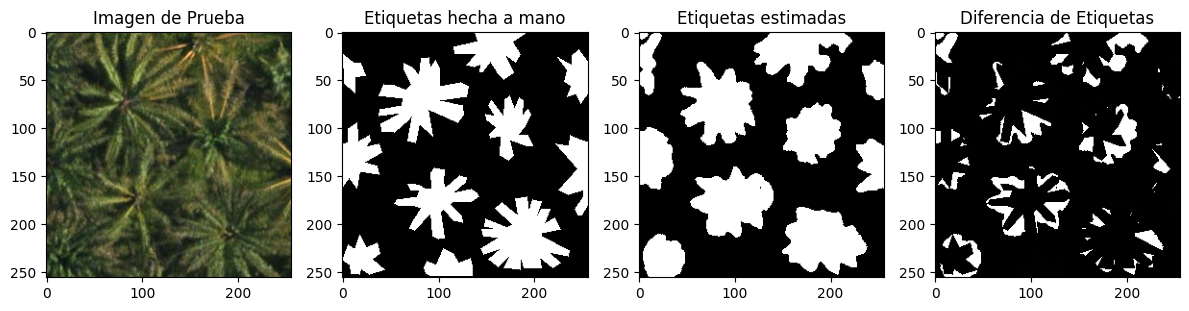

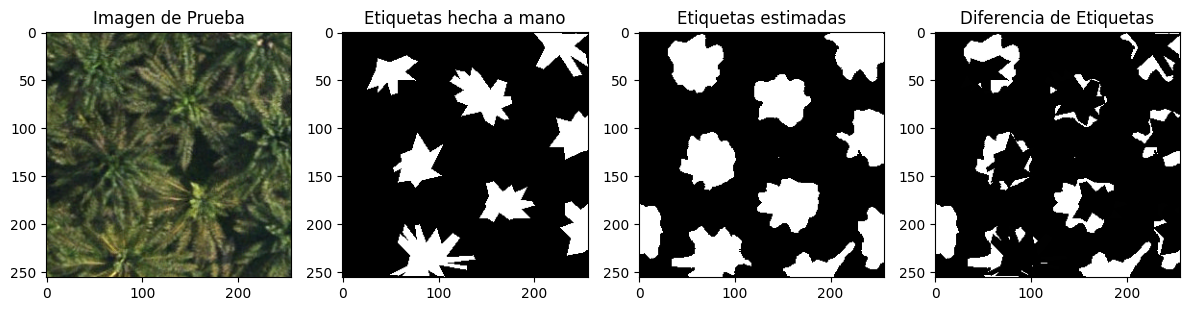

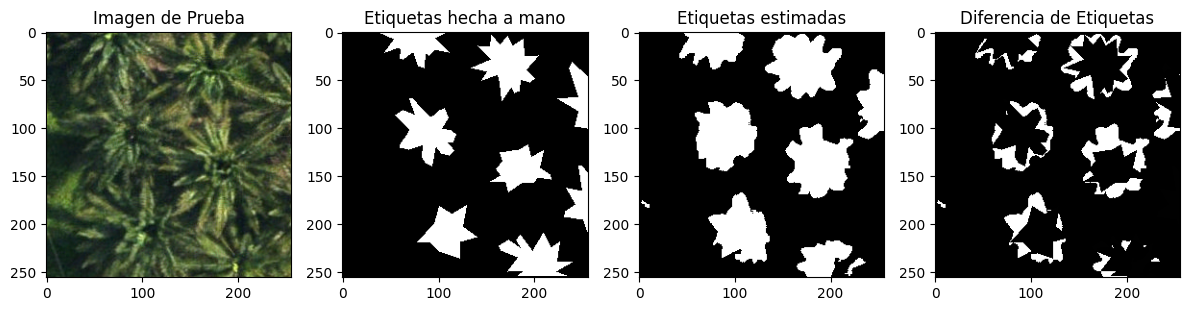

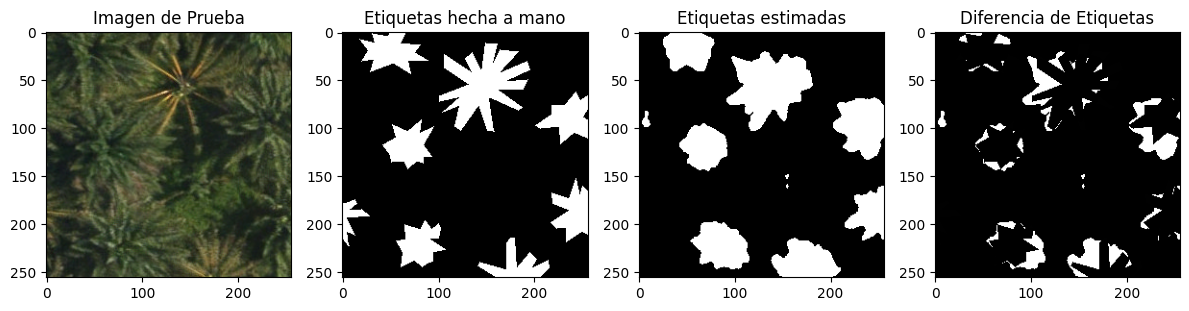

In [15]:
Y_test_pred = model.predict(X_test, verbose=1)
Y_test_diff = np.zeros((val_samples, img_height, img_width, img_channels), dtype= 'uint8')
for i in range(val_samples):
    Y_test_pred[i]   = normalize(Y_test_pred[i])
    Y_test_pred[i] = (Y_test_pred[i]>0.1).astype(np.uint8)
    Y_test_diff[i] = np.abs(Y_test[i].astype('uint8') - Y_test_pred[i].astype('uint8'))

for i in range(val_samples):
    fig, axs = plt.subplots(1,4, figsize = (12,4))
    
    axs[0].imshow(X_test[i],cmap='gray')
    axs[0].set_title('Imagen de Prueba')
    
    axs[1].imshow(Y_test[i], cmap='gray')
    axs[1].set_title('Etiquetas hecha a mano')
    
    axs[2].imshow(Y_test_pred[i], cmap='gray')
    axs[2].set_title('Etiquetas estimadas')

    axs[3].imshow(Y_test_diff[i], cmap='gray')
    axs[3].set_title('Diferencia de Etiquetas')
    
    plt.tight_layout()
    plt.show()

In [16]:
for i in range(val_samples):
    Y_val  = Y_test[i]
    Y_pred = Y_test_pred[i]
    FP = len(np.where(Y_pred - Y_val  == 1)[0])/len(np.where(Y_val  == 0)[0]) 
    FN = len(np.where(Y_pred - Y_val  == -1)[0])/len(np.where(Y_val  == 1)[0])
    TP = len(np.where(Y_pred + Y_val  == 2)[0])/len(np.where(Y_val  == 1)[0])
    TN = len(np.where(Y_pred + Y_val  == 0)[0])/len(np.where(Y_val  == 0)[0]) 
    Cmat = np.array([[TP, FN], [FP, TN]])*100
    print(Cmat)
    print('\n')

[[98.74  1.26]
 [13.66 86.34]]


[[96.66  3.34]
 [17.28 82.72]]


[[97.89  2.11]
 [17.94 82.06]]


[[97.56  2.44]
 [12.63 87.37]]


[[92.2  7.8]
 [19.8 80.2]]


[[94.85  5.15]
 [20.97 79.03]]


[[81.05 18.95]
 [16.92 83.08]]


[[86.92 13.08]
 [17.48 82.52]]


[[85.88 14.12]
 [13.73 86.27]]


[[83.35 16.65]
 [ 9.44 90.56]]


